# Notebook 1: Dataset Understanding

## Project: Satellite Image-Based Oil Spill Detection using SAR Images

**Infosys AI Internship Project**

**Target Accuracy: 94-96%** using Enhanced U-Net with Attention Mechanisms

---

### 🚀 Kaggle-Ready Notebook

**This notebook is optimized for Kaggle!**

Simply upload this notebook to Kaggle and add your dataset.

---

### Objective
This notebook focuses on understanding the dataset structure before performing any processing or analysis.

### What is SAR?
**SAR (Synthetic Aperture Radar)** is a satellite imaging technology that uses radar signals to capture images of Earth's surface. Unlike optical images, SAR works in all weather conditions and at night.

### Problem Statement
- **Task**: Binary Image Segmentation
- **Input**: SAR satellite images (RGB or Grayscale)
- **Output**: Binary segmentation masks (Oil Spill vs Background)
- **Goal**: Detect and segment oil spills in marine environments with high accuracy

### Expected Dataset Structure
```
dataset/
├── train/
│   ├── images/    # Training SAR images (.jpg/.jpeg)
│   └── masks/     # Training masks (.png)
├── val/
│   ├── images/    # Validation images
│   └── masks/     # Validation masks
└── test/
    ├── images/    # Test images
    └── masks/     # Test masks
```

**Note**: This is the standard structure used in professional ML projects for proper train/val/test split.

---
## 1. Environment Setup

This section detects the environment (Kaggle or local).

In [1]:
# Check if running on Kaggle
import os
try:
    if os.path.exists('/kaggle/input'):
        ON_KAGGLE = True
        print("✓ Running on Kaggle")
    else:
        ON_KAGGLE = False
        print("✓ Running on local environment")
except:
    ON_KAGGLE = False
    print("✓ Running on local environment")

✓ Running on Kaggle


### Kaggle Dataset Configuration

If your dataset is added as a Kaggle dataset, the path will be automatically detected. Otherwise, update the paths below.

In [2]:
# Kaggle dataset paths
if ON_KAGGLE:
    print("\n✓ Kaggle environment detected")
    print("\nKaggle datasets are mounted at: /kaggle/input/")
    print("\nAvailable datasets:")
    kaggle_input = '/kaggle/input'
    if os.path.exists(kaggle_input):
        datasets = [d for d in os.listdir(kaggle_input) if os.path.isdir(os.path.join(kaggle_input, d))]
        for dataset in datasets:
            print(f"  - {dataset}")
    print("\nUpdate the DATA_DIR variable in the next section with your dataset name.")
else:
    print("Not on Kaggle - using local paths")


✓ Kaggle environment detected

Kaggle datasets are mounted at: /kaggle/input/

Available datasets:
  - oilspill

Update the DATA_DIR variable in the next section with your dataset name.


In [3]:
# Define dataset paths
import zipfile
from pathlib import Path

# Auto-detect Kaggle dataset or use local path
if ON_KAGGLE:
    # Try to auto-detect dataset in /kaggle/input/
    kaggle_input = Path('/kaggle/input')
    potential_datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    
    # Look for a dataset with train/val/test structure
    BASE_DATA_DIR = None
    for dataset_dir in potential_datasets:
        if (dataset_dir / 'train').exists() or (dataset_dir / 'train' / 'images').exists():
            BASE_DATA_DIR = dataset_dir
            print(f"✓ Auto-detected dataset: {dataset_dir.name}")
            break
    
    # If nested, check subdirectories
    if BASE_DATA_DIR is None:
        for dataset_dir in potential_datasets:
            subdirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
            for subdir in subdirs:
                if (subdir / 'train').exists() or (subdir / 'train' / 'images').exists():
                    BASE_DATA_DIR = subdir
                    print(f"✓ Auto-detected dataset in: {subdir}")
                    break
            if BASE_DATA_DIR:
                break
    
    if BASE_DATA_DIR is None:
        print("⚠ Could not auto-detect dataset. Please set BASE_DATA_DIR manually.")
        # Example: BASE_DATA_DIR = Path('/kaggle/input/your-dataset-name')
        BASE_DATA_DIR = kaggle_input / potential_datasets[0] if potential_datasets else kaggle_input
else:
    BASE_DATA_DIR = Path('dataset')

print(f"\n✓ Using BASE_DATA_DIR: {BASE_DATA_DIR}")
print("✓ Setup complete. Proceed to the next section.")

✓ Auto-detected dataset in: /kaggle/input/oilspill/oil_spill_dataset

✓ Using BASE_DATA_DIR: /kaggle/input/oilspill/oil_spill_dataset
✓ Setup complete. Proceed to the next section.


---
## 2. Import Required Libraries

In [4]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display parameters
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---
## 3. Load Dataset Paths

**For Kaggle users**:
- Your dataset is automatically mounted at `/kaggle/input/`
- The notebook will auto-detect your dataset structure
- No manual configuration needed!

In [5]:
# ============================================================================
# DATASET PATH CONFIGURATION
# ============================================================================

import zipfile

# Define BASE_DATA_DIR based on environment
if ON_KAGGLE:
    BASE_DATA_DIR = Path('/kaggle/input/oilspill/oil_spill_dataset')
    
    # Auto-detect dataset folder
    if BASE_DATA_DIR.exists():
        contents = list(BASE_DATA_DIR.iterdir())
        # If there's exactly one subfolder and it's a directory, use that
        if len(contents) == 1 and contents[0].is_dir():
            nested_folder = contents[0]
            print(f"\n🔍 Detected nested folder: {nested_folder.name}")
            
            # Check if this nested folder has train/val/test structure
            has_train = (nested_folder / 'train').exists()
            has_val = (nested_folder / 'val').exists()
            has_test = (nested_folder / 'test').exists()
            
            if has_train or has_val or has_test:
                BASE_DATA_DIR = nested_folder
                print(f"✓ Automatically adjusted BASE_DATA_DIR to: {BASE_DATA_DIR}")
else:
    # For local environment
    BASE_DATA_DIR = Path('dataset')

print(f"\n🎯 Using BASE_DATA_DIR: {BASE_DATA_DIR}")

# STEP 3: Define train/val/test splits
TRAIN_DIR = BASE_DATA_DIR / 'train'
VAL_DIR = BASE_DATA_DIR / 'val'
TEST_DIR = BASE_DATA_DIR / 'test'

# Define image and mask subdirectories
TRAIN_IMAGES = TRAIN_DIR / 'images'
TRAIN_MASKS = TRAIN_DIR / 'masks'
VAL_IMAGES = VAL_DIR / 'images'
VAL_MASKS = VAL_DIR / 'masks'
TEST_IMAGES = TEST_DIR / 'images'
TEST_MASKS = TEST_DIR / 'masks'

# STEP 4: Verify directory structure
print("\n" + "="*70)
print("DIRECTORY VERIFICATION")
print("="*70)
print(f"Current working directory: {os.getcwd()}")
print(f"Base dataset directory: {BASE_DATA_DIR.absolute()}")
print()

directories = [
    (TRAIN_IMAGES, 'Train Images'),
    (TRAIN_MASKS, 'Train Masks'),
    (VAL_IMAGES, 'Val Images'),
    (VAL_MASKS, 'Val Masks'),
    (TEST_IMAGES, 'Test Images'),
    (TEST_MASKS, 'Test Masks')
]

all_found = True
for dir_path, dir_name in directories:
    if dir_path.exists():
        file_count = len([f for f in dir_path.iterdir() if f.is_file()])
        print(f"✓ {dir_name:20s}: {file_count:4d} files")
    else:
        print(f"✗ {dir_name:20s}: NOT FOUND")
        all_found = False

print("="*70)

# STEP 5: Provide guidance if directories are missing
if not all_found:
    print("\n⚠ Warning: Some directories not found!")
    
    if ON_KAGGLE:
        print("\n🔍 Troubleshooting:")
        if BASE_DATA_DIR.exists():
            print(f"\n   📂 Contents of {BASE_DATA_DIR}:")
            for item in sorted(BASE_DATA_DIR.iterdir()):
                if item.is_dir():
                    print(f"      📁 {item.name}/")
                    # Show subdirectories
                    for subitem in sorted(item.iterdir())[:3]:
                        if subitem.is_dir():
                            print(f"         📁 {subitem.name}/")
                else:
                    print(f"      📄 {item.name}")
    
    print("\n📁 Expected dataset structure:")
    print("""
    BASE_DATA_DIR/
    ├── train/
    │   ├── images/    # Training SAR images (.jpg/.jpeg)
    │   └── masks/     # Training masks (.png)
    ├── val/
    │   ├── images/    # Validation images
    │   └── masks/     # Validation masks
    └── test/
        ├── images/    # Test images
        └── masks/     # Test masks
    """)
    
    if ON_KAGGLE:
        print("\n💡 On Kaggle:")
        print("   1. Make sure your dataset is added to the notebook (Add Data)")
        print("   2. Check that your dataset has the correct folder structure")
        print("   3. Refresh the kernel if you just added the dataset")
    else:
        print("\n💡 For local environment:")
        print("   1. Place your dataset in the 'dataset' folder")
        print("   2. Ensure the folder structure matches the expected layout")
        print("   3. Check file permissions")

if all_found:
    print("\n✓ All directories found! Ready to proceed with data exploration.")


🎯 Using BASE_DATA_DIR: /kaggle/input/oilspill/oil_spill_dataset

DIRECTORY VERIFICATION
Current working directory: /kaggle/working
Base dataset directory: /kaggle/input/oilspill/oil_spill_dataset

✓ Train Images        : 3848 files
✓ Train Masks         : 3848 files
✓ Val Images          : 1615 files
✓ Val Masks           : 1615 files
✓ Test Images         : 2606 files
✓ Test Masks          : 2606 files

✓ All directories found! Ready to proceed with data exploration.


---
## 4. Dataset Statistics

Let's analyze the dataset distribution across train/val/test splits.

In [6]:
# Count files in each split
def count_files(directory):
    """Count files in a directory"""
    if directory.exists():
        return len([f for f in directory.iterdir() if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    return 0

# Get counts
train_images_count = count_files(TRAIN_IMAGES)
train_masks_count = count_files(TRAIN_MASKS)
val_images_count = count_files(VAL_IMAGES)
val_masks_count = count_files(VAL_MASKS)
test_images_count = count_files(TEST_IMAGES)
test_masks_count = count_files(TEST_MASKS)

total_images = train_images_count + val_images_count + test_images_count
total_masks = train_masks_count + val_masks_count + test_masks_count

# Display statistics
print("="*70)
print("DATASET STATISTICS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   Images: {train_images_count}")
print(f"   Masks:  {train_masks_count}")
if train_images_count > 0:
    print(f"   Match:  {'✓ Yes' if train_images_count == train_masks_count else '✗ No'}")

print(f"\n📊 Validation Set:")
print(f"   Images: {val_images_count}")
print(f"   Masks:  {val_masks_count}")
if val_images_count > 0:
    print(f"   Match:  {'✓ Yes' if val_images_count == val_masks_count else '✗ No'}")

print(f"\n📊 Test Set:")
print(f"   Images: {test_images_count}")
print(f"   Masks:  {test_masks_count}")
if test_images_count > 0:
    print(f"   Match:  {'✓ Yes' if test_images_count == test_masks_count else '✗ No'}")

print(f"\n📊 Total Dataset:")
print(f"   Total Images: {total_images}")
print(f"   Total Masks:  {total_masks}")

# Calculate split percentages
if total_images > 0:
    train_pct = (train_images_count / total_images) * 100
    val_pct = (val_images_count / total_images) * 100
    test_pct = (test_images_count / total_images) * 100
    
    print(f"\n📈 Split Distribution:")
    print(f"   Train: {train_pct:.1f}%")
    print(f"   Val:   {val_pct:.1f}%")
    print(f"   Test:  {test_pct:.1f}%")
    
    # Check if split is reasonable
    if 60 <= train_pct <= 80 and 10 <= val_pct <= 20 and 10 <= test_pct <= 20:
        print(f"\n   ✓ Split distribution looks good!")
    else:
        print(f"\n   ⚠ Unusual split distribution (typically 70-15-15 or 80-10-10)")
else:
    print("\n⚠ No data found. Please add your dataset.")

print("="*70)

DATASET STATISTICS

📊 Training Set:
   Images: 3848
   Masks:  3848
   Match:  ✓ Yes

📊 Validation Set:
   Images: 1615
   Masks:  1615
   Match:  ✓ Yes

📊 Test Set:
   Images: 2606
   Masks:  2606
   Match:  ✓ Yes

📊 Total Dataset:
   Total Images: 8069
   Total Masks:  8069

📈 Split Distribution:
   Train: 47.7%
   Val:   20.0%
   Test:  32.3%

   ⚠ Unusual split distribution (typically 70-15-15 or 80-10-10)


---
## 5. Check File Formats

Understanding the file formats helps us choose the correct loading method.

In [7]:
# Get list of image and mask files from training set
if train_images_count > 0:
    image_files = [f.name for f in TRAIN_IMAGES.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']]
    image_extensions = list(set([f.suffix.lower() for f in TRAIN_IMAGES.iterdir() if f.is_file()]))
    
    print("Image file formats found:")
    for ext in sorted(image_extensions):
        count = sum(1 for f in image_files if f.endswith(ext))
        if count > 0:
            print(f"  - {ext}: {count} files")
else:
    print("No image files found.")

print()

# Extract file extensions from masks
if train_masks_count > 0:
    mask_files = [f.name for f in TRAIN_MASKS.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']]
    mask_extensions = list(set([f.suffix.lower() for f in TRAIN_MASKS.iterdir() if f.is_file()]))
    
    print("Mask file formats found:")
    for ext in sorted(mask_extensions):
        count = sum(1 for f in mask_files if f.endswith(ext))
        if count > 0:
            print(f"  - {ext}: {count} files")
else:
    print("No mask files found.")

Image file formats found:
  - .png: 3848 files

Mask file formats found:
  - .png: 3848 files


---
## 6. Display Sample Filenames

Let's look at a few sample filenames to understand the naming convention.

In [8]:
# Get list of image and mask files from training set
if train_images_count > 0:
    image_files = sorted([f.name for f in TRAIN_IMAGES.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    
    print("Sample Image Filenames:")
    print("-" * 50)
    for i, filename in enumerate(image_files[:5], 1):
        print(f"{i}. {filename}")
    if len(image_files) > 5:
        print(f"   ... and {len(image_files) - 5} more")
else:
    print("Sample Image Filenames:")
    print("-" * 50)
    print("No images available.")

print("\n" + "="*50 + "\n")

# Display first 5 mask filenames
if train_masks_count > 0:
    mask_files = sorted([f.name for f in TRAIN_MASKS.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    
    print("Sample Mask Filenames:")
    print("-" * 50)
    for i, filename in enumerate(mask_files[:5], 1):
        print(f"{i}. {filename}")
    if len(mask_files) > 5:
        print(f"   ... and {len(mask_files) - 5} more")
else:
    print("Sample Mask Filenames:")
    print("-" * 50)
    print("No masks available.")

Sample Image Filenames:
--------------------------------------------------
1. palsar_0.png
2. palsar_1.png
3. palsar_10.png
4. palsar_1000.png
5. palsar_1002.png
   ... and 3843 more


Sample Mask Filenames:
--------------------------------------------------
1. palsar_0.png
2. palsar_1.png
3. palsar_10.png
4. palsar_1000.png
5. palsar_1002.png
   ... and 3843 more


---
## 7. Load and Inspect Image & Mask Dimensions

We'll load a sample image and mask to check their properties.

In [9]:
# Load first image and mask from training set (if available)
if train_images_count > 0 and train_masks_count > 0:
    # Get first image and mask files (all supported formats)
    image_files = sorted([f for f in TRAIN_IMAGES.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    mask_files = sorted([f for f in TRAIN_MASKS.iterdir() if f.suffix.lower() in ['.png', '.jpg', '.jpeg', '.tif', '.tiff']])
    
    if image_files and mask_files:
        # Load sample image (can be RGB or grayscale SAR image)
        sample_image_path = image_files[0]
        sample_image = cv2.imread(str(sample_image_path))
        sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        
        # Load sample mask
        sample_mask_path = mask_files[0]
        sample_mask = cv2.imread(str(sample_mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Display information
        print("SAMPLE IMAGE PROPERTIES")
        print("=" * 70)
        print(f"Filename: {sample_image_path.name}")
        print(f"Shape: {sample_image_rgb.shape}")
        print(f"Height: {sample_image_rgb.shape[0]} pixels")
        print(f"Width: {sample_image_rgb.shape[1]} pixels")
        print(f"Channels: {sample_image_rgb.shape[2]} (RGB)" if len(sample_image_rgb.shape) == 3 else "1 (Grayscale)")
        print(f"Data type: {sample_image_rgb.dtype}")
        print(f"Min pixel value: {sample_image_rgb.min()}")
        print(f"Max pixel value: {sample_image_rgb.max()}")
        print(f"Mean pixel value: {sample_image_rgb.mean():.2f}")
        
        print("\n" + "=" * 70 + "\n")
        
        print("SAMPLE MASK PROPERTIES")
        print("=" * 70)
        print(f"Filename: {sample_mask_path.name}")
        print(f"Shape: {sample_mask.shape}")
        print(f"Height: {sample_mask.shape[0]} pixels")
        print(f"Width: {sample_mask.shape[1]} pixels")
        print(f"Data type: {sample_mask.dtype}")
        print(f"Unique values: {np.unique(sample_mask)}")
        print(f"Min value: {sample_mask.min()}")
        print(f"Max value: {sample_mask.max()}")
        
        # Calculate oil spill coverage
        if sample_mask.max() > 0:
            oil_spill_pixels = np.sum(sample_mask > 0)
            total_pixels = sample_mask.shape[0] * sample_mask.shape[1]
            coverage = (oil_spill_pixels / total_pixels) * 100
            print(f"\nOil Spill Coverage: {coverage:.2f}% of image")
        
        # Check if dimensions match
        print("\n" + "=" * 70)
        if sample_image_rgb.shape[:2] == sample_mask.shape:
            print("✓ Image and mask dimensions match!")
        else:
            print("⚠ Warning: Image and mask dimensions don't match!")
            print(f"  Image shape: {sample_image_rgb.shape[:2]}")
            print(f"  Mask shape: {sample_mask.shape}")
else:
    print("⚠ Cannot load samples. Please ensure training dataset is available.")
    sample_image_rgb = None
    sample_mask = None

SAMPLE IMAGE PROPERTIES
Filename: palsar_0.png
Shape: (256, 256, 3)
Height: 256 pixels
Width: 256 pixels
Channels: 3 (RGB)
Data type: uint8
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 155.22


SAMPLE MASK PROPERTIES
Filename: palsar_0.png
Shape: (256, 256)
Height: 256 pixels
Width: 256 pixels
Data type: uint8
Unique values: [  0 255]
Min value: 0
Max value: 255

Oil Spill Coverage: 3.47% of image

✓ Image and mask dimensions match!


---
## 8. Visualize Sample Image-Mask Pair

Let's visualize a SAR image alongside its corresponding segmentation mask.

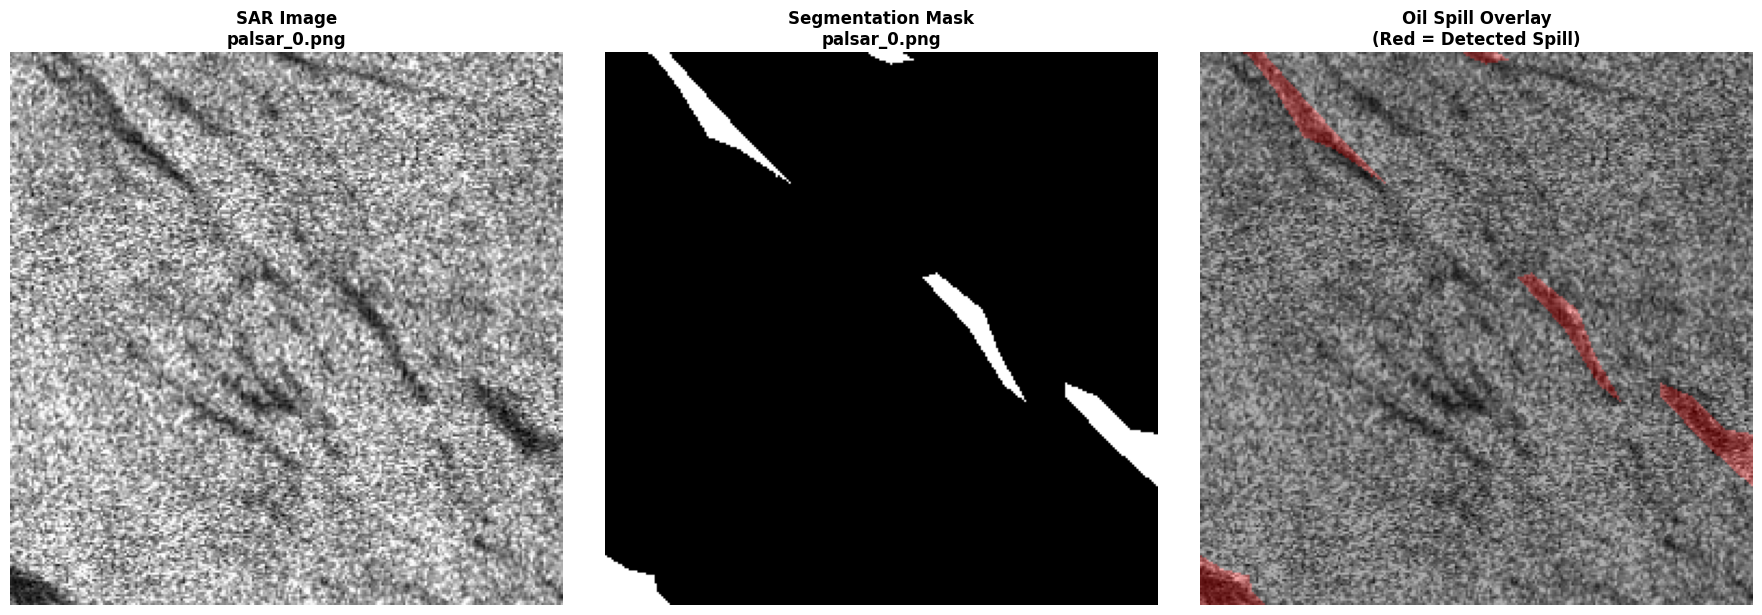


📊 Visualization Notes:
  - Left: Original SAR satellite image
  - Middle: Binary segmentation mask
  - Right: Overlay showing detected oil spills in red
  - White regions in mask indicate oil spill areas
  - Black regions represent background (water/ocean)


In [10]:
# Visualize image and mask side by side
if sample_image_rgb is not None and sample_mask is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display SAR image
    axes[0].imshow(sample_image_rgb)
    axes[0].set_title(f'SAR Image\n{image_files[0].name}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Display mask
    axes[1].imshow(sample_mask, cmap='gray')
    axes[1].set_title(f'Segmentation Mask\n{mask_files[0].name}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Display overlay
    overlay = sample_image_rgb.copy()
    # Create red overlay where mask is positive
    red_mask = np.zeros_like(sample_image_rgb)
    red_mask[:, :, 0] = sample_mask  # Red channel
    # Blend with alpha
    overlay = cv2.addWeighted(overlay, 0.7, red_mask, 0.3, 0)
    axes[2].imshow(overlay)
    axes[2].set_title('Oil Spill Overlay\n(Red = Detected Spill)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Visualization Notes:")
    print("  - Left: Original SAR satellite image")
    print("  - Middle: Binary segmentation mask")
    print("  - Right: Overlay showing detected oil spills in red")
    print("  - White regions in mask indicate oil spill areas")
    print("  - Black regions represent background (water/ocean)")
else:
    print("⚠ Cannot visualize. Dataset not available.")

---
## 9. Check Multiple Samples for Consistency

Let's verify that all images and masks have consistent dimensions.

In [11]:
# Check dimensions of multiple samples from training set
if train_images_count > 0 and train_masks_count > 0:
    print("Checking dimensions of sample files...\n")
    
    # Get file lists
    image_files_list = sorted([f for f in TRAIN_IMAGES.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    mask_files_list = sorted([f for f in TRAIN_MASKS.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']])
    
    image_shapes = []
    mask_shapes = []
    
    # Sample up to 10 files or all files if less than 10
    num_samples = min(10, len(image_files_list), len(mask_files_list))
    
    for i in range(num_samples):
        # Load images using full Path objects
        img = cv2.imread(str(image_files_list[i]))
        msk = cv2.imread(str(mask_files_list[i]), cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            image_shapes.append(img.shape[:2])  # Only height and width
        if msk is not None:
            mask_shapes.append(msk.shape)
    
    # Check if all dimensions are the same
    unique_image_shapes = list(set(image_shapes))
    unique_mask_shapes = list(set(mask_shapes))
    
    print(f"Unique image dimensions found: {unique_image_shapes}")
    print(f"Unique mask dimensions found: {unique_mask_shapes}")
    
    if len(unique_image_shapes) == 1 and len(unique_mask_shapes) == 1:
        print("\n✓ All images and masks have consistent dimensions!")
        print(f"   Standard size: {unique_image_shapes[0][1]}x{unique_image_shapes[0][0]} pixels (W×H)")
    else:
        print("\n⚠ Warning: Inconsistent dimensions detected!")
        print("   Preprocessing will need to resize all images to a standard size (256×256 recommended).")
else:
    print("⚠ Cannot check consistency. Dataset not available.")

Checking dimensions of sample files...

Unique image dimensions found: [(256, 256)]
Unique mask dimensions found: [(256, 256)]

✓ All images and masks have consistent dimensions!
   Standard size: 256x256 pixels (W×H)


---
## 8. Summary

### What We Accomplished:

1. **Environment Setup**: Detected Kaggle or local environment

2. **Dataset Structure Verification**: Confirmed presence of:
   - Training images and masks
   - Validation images and masks
   - Test images and masks

3. **Data Loading**: Loaded sample images and masks for inspection

4. **Basic Inspection**: Examined:
   - Image dimensions (height, width, channels)
   - Mask values (binary or grayscale)
   - File formats (.jpg, .png, etc.)

5. **Data Type Understanding**:
   - SAR images: Typically grayscale or RGB, values 0-255
   - Binary masks with typically 2 unique values (0 and 255, or 0 and 1)
   - Same dimensions as corresponding images
   - White areas represent oil spills, black represents background

6. **Dimension Consistency**: Checked if all images/masks have the same size.

### Next Steps:

- **Notebook 2**: Perform detailed Exploratory Data Analysis (EDA)
- **Notebook 3**: Preprocess images (resize, normalize, denoise)
- **Notebook 4**: Build U-Net segmentation model
- **Notebook 5**: Train the model
- **Notebook 6**: Evaluate and visualize results

---

### 📌 Tips for Running This Notebook:

**Local Environment:**
- Ensure dataset is in `dataset/` folder with train/val/test structure
- Install required packages: `pip install opencv-python numpy matplotlib`

**Kaggle:**
- Add your dataset to the notebook (Add Data button)
- All packages are pre-installed
- Free GPU available for training (covered in Notebook 5)

**Getting Sample Datasets:**
- **Kaggle**: "SAR oil spill detection dataset"
- **Sentinel-1**: ESA Copernicus Hub
- **Academic**: Search for published SAR oil spill datasets

---

**End of Notebook 1** ✓